In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy import stats

In [123]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
bert_model = AutoModel.from_pretrained("allegro/herbert-base-cased") 

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.sso.sso_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.sso.sso_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [124]:
from bert_transformer import BertTransformer

bert_transformer = BertTransformer(tokenizer, bert_model, max_length=60)

In [125]:
X_string = 'nlp_2', 'nlp_3', 'nlp_4', 'nlp_5'
Y_string = 'GDT_score'
DATASET = 'NLP_CLEAN.xlsx'

In [126]:
def del_short_responses(df):
    print(len(df))

    for item in [f'nlp_{i}' for i in range(2, 6)]:
        df = df[df[item].apply(lambda x: len(x) > 10)]
        print(len(df))

    return df

In [127]:
df = pd.read_excel(io=DATASET)
print(len(df))
df = df[df['time'] > 300]
df = df[df['label'] != 1]
df = del_short_responses(df)

522
469
468
460
449
433


In [128]:
df_pilot = pd.read_excel('NLP_PILOT.XLSX')
df_pilot = del_short_responses(df_pilot)

95
95
94
92
91


In [129]:
def transform_and_stack(df, arguments=X_string, transformer=bert_transformer):
    tokenized_X_list = []

    for item in arguments:

        item_processed = transformer.transform(list(df[item]))
        tokenized_X_list.append(item_processed)
        print(f'{item} added to list')
        time.sleep(0.5)

    tokized_X_tuple = tuple(tokenized_X_list)

    X = np.hstack(tokized_X_tuple)
    y = df[Y_string].values
    return X, y

In [130]:
X_main, y_main = transform_and_stack(df)

nlp_5 added to list


In [131]:
X_pilot, y_pilot = transform_and_stack(df_pilot)

nlp_5 added to list


In [132]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

kfold = KFold(n_splits=10, shuffle=True, random_state=8)

In [145]:
from sklearn import svm

SVR_function = svm.SVR(kernel='linear', C=0.018, tol=1e-3)

y_main_true = []
SVR_predictions = []


for train_index, test_index in kfold.split(X_main):

    X_train, X_test = X_main[train_index], X_main[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]

    vector_regression = SVR_function
    vector_regression.fit(X_train, y_train)
    SVR_prediction = vector_regression.predict(X_test)
    SVR_predictions = np.concatenate((SVR_predictions, SVR_prediction))

    y_main_true = np.concatenate((y_main_true, y_test))

stats.pearsonr(SVR_predictions, y_main_true)

PearsonRResult(statistic=0.4405140312680437, pvalue=5.56559075162059e-22)

In [146]:
def present_results(prediction, true_values):
    prediction = [item if item >= 4 else 4 for item in prediction]
    prediction = [item if item <= 20 else 20 for item in prediction]

    answers_tuples = [(y, res) for y, res in zip(true_values, prediction)]
    sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

    sorted_results = [x[1] for x in sorted_tuples]

    true_values = [x[0] for x in sorted_tuples]
    prediction = [round(int(item)) for item in sorted_results]

    plt.figure(figsize=(10, 7))
    plt.plot(range(len(prediction)), prediction, 'o', color=[1, 0, 0, 0.7], label="Prediction")
    plt.plot(range(len(true_values)), true_values, 'o', color=[0, 1, 0, 0.5], label='Observable data')
    plt.legend(loc='upper left')
    plt.title('Connected predictions vs real data')
    plt.show()
    
    print(f'MAE: {mean_absolute_error(prediction, true_values)}')
    print(stats.pearsonr(prediction, true_values))

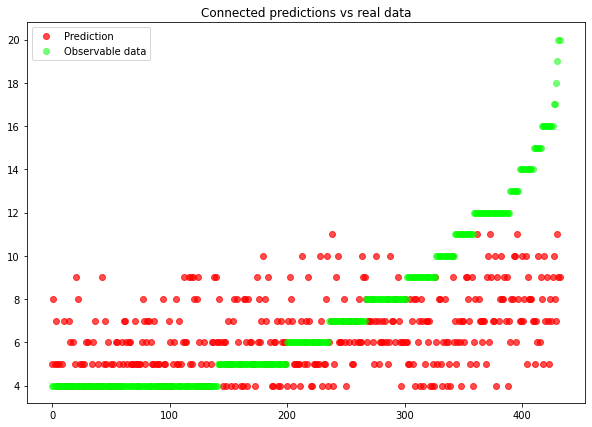

MAE: 2.4942263279445727
PearsonRResult(statistic=0.430989638853276, pvalue=5.173121262002968e-21)


In [147]:
present_results(SVR_predictions, y_main_true)

In [148]:
SVR_pilot_predictions = SVR_function.predict(X_pilot)
stats.pearsonr(SVR_pilot_predictions, y_pilot)

PearsonRResult(statistic=0.2768160174699566, pvalue=0.00790096578471985)

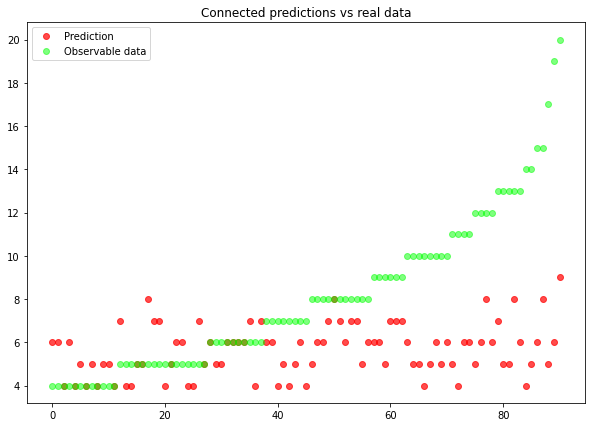

MAE: 3.0
PearsonRResult(statistic=0.28408414700935936, pvalue=0.00635276261573187)


In [149]:
present_results(SVR_pilot_predictions, y_pilot)